# Identifying Entities in Healthcare Data

### Workspace set up: Import and Install useful packages.

In [1]:
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

### Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

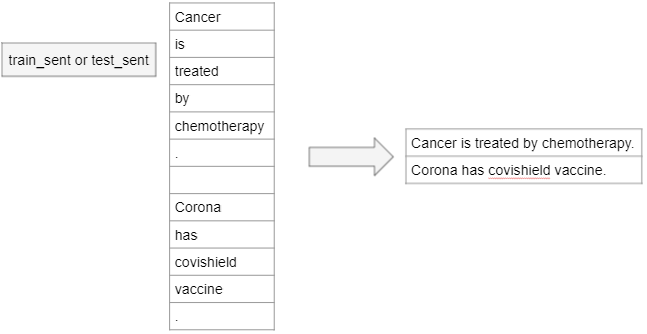

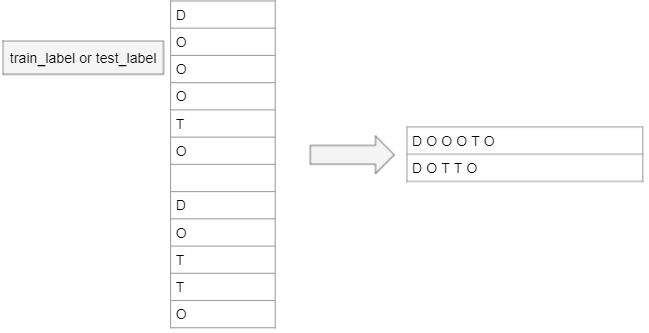

In [2]:
with open('/Users/Kirwe-Macbook/Desktop/PGDML/NLP/Syntactic processing assignment/train_sent', 'r') as train_sent_file:
  train_sentences = train_sent_file.readlines()

with open('/Users/Kirwe-Macbook/Desktop/PGDML/NLP/Syntactic processing assignment/train_label', 'r') as train_labels_file:
  train_labels = train_labels_file.readlines()

with open('/Users/Kirwe-Macbook/Desktop/PGDML/NLP/Syntactic processing assignment/test_sent', 'r') as test_sent_file:
  test_sentences = test_sent_file.readlines()

with open('/Users/Kirwe-Macbook/Desktop/PGDML/NLP/Syntactic processing assignment/test_label', 'r') as test_labels_file:
  test_labels = test_labels_file.readlines()

In [3]:
len(train_sentences), len(train_labels),len(test_sentences), len(test_labels)

(48501, 48501, 19674, 19674)

### Data preprocessing for train sentences

In [4]:
processed_train_sentences= []
sentence = []
for word in train_sentences:
    if word.isspace():
        res = " ".join(sentence)
        processed_train_sentences.append(res)
        sentence = []
    else:
        word=word.strip()
        sentence.append(word)

In [5]:
processed_train_sentences[0]

'All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )'

### Data preprocessing for test sentences

In [6]:
processed_test_sentences= []
sentence = []
for word in test_sentences:
    if word.isspace():
        res = " ".join(sentence)
        processed_test_sentences.append(res)
        sentence = []
    else:
        word=word.strip()
        sentence.append(word)

In [7]:
processed_test_sentences[46]

'< TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy'

### Data preprocessing for train labels

In [8]:
processed_train_labels= []
labels = []
for word in train_labels:
    if word.isspace():
        res = " ".join(labels)
        processed_train_labels.append(res)
        labels = []
    else:
        word=word.strip()
        labels.append(word)

In [9]:
processed_train_labels[0]

'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O'

### Data preprocessing for test labels

In [10]:
processed_test_labels= []
labels = []
for word in test_labels:
    if word.isspace():
        res = " ".join(labels)
        processed_test_labels.append(res)
        labels = []
    else:
        word=word.strip()
        labels.append(word)

In [11]:
processed_test_labels[46]

'O O O O O O O O O O O O O O O O O O O O O O O O O'

In [12]:
for x in range(0,5):
    print("**********")
    print("Sentence number %d" %x)
    print(processed_train_sentences[x])
    print("Label number %d" %x)
    print(processed_train_labels[x])

**********
Sentence number 0
All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Label number 0
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
**********
Sentence number 1
The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Label number 1
O O O O O O O O O O O O O O O O O O O O O O O O O
**********
Sentence number 2
Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Label number 2
O O O O O O O O O O O O O O O
**********
Sentence number 3
The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Label number 3
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

In [13]:
for x in range(0,5):
    print("**********")
    print("Sentence number %d" %x)
    print(processed_test_sentences[x])
    print("Label number %d" %x)
    print(processed_test_labels[x])

**********
Sentence number 0
Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
Label number 0
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
**********
Sentence number 1
As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration
Label number 1
O O O O O O O O O O O O O O O O O O O
**********
Sentence number 2
The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period
Label number 2
O O O O O O O O O O O O O O O O O O O O O O O O
**********
Sentence number 3
There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )
Label number 3
O O O O O O O O O O O O O O

### Count the number of sentences in the processed train and test dataset 

In [14]:
len(processed_train_sentences), len(processed_test_sentences)

(2599, 1056)

### Count the number of lines of labels in the processed train and test dataset.

In [15]:
len(processed_train_labels), len(processed_test_labels)

(2599, 1056)

## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [16]:
model = spacy.load("en_core_web_sm")

train_count = 0

for i in range(0,len(processed_train_sentences)):
    sent = model(processed_train_sentences[i])

    for token in sent:
        if(token.pos_ in ["NOUN","PROPN"]):
            train_count=train_count+1

print("TRAIN SET = Total count of words which are NOUN or PROPN = ", train_count)

TRAIN SET = Total count of words which are NOUN or PROPN =  17392


In [17]:
test_count = 0

for i in range(0,len(processed_test_sentences)):
    sent = model(processed_test_sentences[i])

    for token in sent:
        if(token.pos_ in ["NOUN","PROPN"]):
            test_count=test_count+1

print("TEST SET = Total count of words which are NOUN or PROPN = ", test_count)

TEST SET = Total count of words which are NOUN or PROPN =  6910


### Checking for POS tag of one specific sentence for quick overview

In [36]:
sent = model(processed_train_sentences[0])

for token in sent:
    print(token.text, "--", token.lemma_, "--", token.pos_)

All -- all -- DET
live -- live -- ADJ
births -- birth -- NOUN
> -- > -- X
or -- or -- CCONJ
= -- = -- SYM
23 -- 23 -- NUM
weeks -- week -- NOUN
at -- at -- ADP
the -- the -- DET
University -- University -- PROPN
of -- of -- ADP
Vermont -- Vermont -- PROPN
in -- in -- ADP
1995 -- 1995 -- NUM
( -- ( -- PUNCT
n -- n -- NOUN
= -- = -- SYM
2395 -- 2395 -- NUM
) -- ) -- PUNCT
were -- be -- AUX
retrospectively -- retrospectively -- ADV
analyzed -- analyze -- VERB
for -- for -- ADP
delivery -- delivery -- NOUN
route -- route -- NOUN
, -- , -- PUNCT
indication -- indication -- NOUN
for -- for -- ADP
cesarean -- cesarean -- PROPN
, -- , -- PUNCT
gestational -- gestational -- ADJ
age -- age -- NOUN
, -- , -- PUNCT
parity -- parity -- NOUN
, -- , -- PUNCT
and -- and -- CCONJ
practice -- practice -- NOUN
group -- group -- NOUN
( -- ( -- PUNCT
to -- to -- PART
reflect -- reflect -- VERB
risk -- risk -- NOUN
status -- status -- NOUN
) -- ) -- PUNCT


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [19]:
model = spacy.load("en_core_web_sm")

most_common_tokens = []

for i in range(0,len(processed_train_sentences)):
    sent = model(processed_train_sentences[i])

    for token in sent:
        if(token.pos_ in ["NOUN","PROPN"]):
            most_common_tokens.append(token.lemma_.lower())
            

for j in range(0,len(processed_test_sentences)):
    sent = model(processed_test_sentences[j])

    for token in sent:
        if(token.pos_ in ["NOUN","PROPN"]):
            most_common_tokens.append(token.lemma_.lower())

In [20]:
most_common_tokens = pd.Series(most_common_tokens)
most_common_tokens.value_counts().head(25)

patient         565
treatment       316
%               247
study           236
cancer          226
cell            202
therapy         182
effect          181
disease         170
group           145
case            132
lung            120
gene            111
rate            103
chemotherapy     91
use              90
trial            90
conclusion       89
woman            89
result           87
analysis         86
protein          82
response         81
year             79
risk             78
dtype: int64

## Defining features for CRF
After exploring the train_sentence and train_label text corpus, we have found some common frequrntly occuring naming patterns for Disease and Treatment labels and hence some features have been defined considering such patterns.
Below are some examples : <br><br>
<b>Treatment words ending with 'tion'</b> = radiation, implantation, anticogulation<br>
<b>Treatment words ending with 'tic'</b> = antipileptic, anitbiotic<br>
<b>Treatment words ending with 'omy'</b> = vitrecomy, prostatectomy <br>
<b>Treatment words ending with 'ery'</b> = surgery, artery<br>
<b>Treatment words ending with 'apy'</b> = monotherapy, therapy<br>
<b>Treatment words starting with 'anti'</b> = antibiotic<br><br>

<b>Disease words ending with 'oma'</b> = Retinoblastoma, melanoma, adenocarcinoma<br>
<b>Treatment words ending with 'onal'</b> = gestational <br>


In [21]:
def getPOStag(word):
    for a in word:
        return(a.pos_)
    
def getLast3chars(word):
    if word[-3:] in ["mic","ery","ear","tic","apy","tic","omy","ese","tes","ome","ial","oma","sis","ary","hea","gus"]:
        return "1"
    else:
        return "0"
    
def getLast4chars(word):
    if word[-4:] in ["gery","tion","ment","lear","date","ptic","elet","sive","sion","mine","esis","rgic","tomy","nary","rugs","llin","ides","mide","bial","tery","ytic","onal","rial","ease","thma","enza"]:
        return "1"
    else:
        return "0"
    
def getFirst4chars(word):
    if word[0:4] in ["anti","cycl","impl","mono","gest","diab","mito","mela","meta"]:
        return "1"
    else:
        return "0"

In [22]:
# Let's define the features to get the feature value for one word.
#Define a function to get the above defined features for a word.

def getFeaturesForOneWord(sentence, pos):
  word = sentence[pos]
  doc1=model(word)

  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter  
    'word[-3:]=' + word[-3:],
    'word[-4:]=' + word[-4:], #Added later
    'word[0:4]=' + word[0:4], #Added later
    'last3=%s' % getLast3chars(word),
    'last4=%s' % getLast4chars(word),
    'first4=%s' % getFirst4chars(word),
    'word.POStag=%s' % getPOStag(doc1)
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    doc2=model(prev_word)
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word[-3:]=' + prev_word[-3:],
    'prev_word.POStag=%s' % getPOStag(doc2)
  ])
  else:
    features.append('BEG') # feature to track begin of sentence 

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [23]:
# Write a code to get features for a sentence.
# Define a function to get features for a sentence 
# using the 'getFeaturesForOneWord' function.
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [24]:
# Write a code to get the labels for a sentence.
# Define a function to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [25]:
print("Generating features for Train sentences")
X_train = [getFeaturesForOneSentence(sentence) for sentence in tqdm(processed_train_sentences)]
print("Generating features for Test sentences")
X_test = [getFeaturesForOneSentence(sentence) for sentence in tqdm(processed_test_sentences)]

Generating features for Train sentences


100%|██████████| 2599/2599 [09:27<00:00,  4.58it/s]


Generating features for Test sentences


100%|██████████| 1056/1056 [03:48<00:00,  4.63it/s]


### Define the labels as the target variable for test and the train dataset

In [26]:
print("Generating features for Train labels")
Y_train = [getLabelsInListForOneSentence(labels) for labels in tqdm(processed_train_labels)]
print("Generating features for Test labels")
Y_test = [getLabelsInListForOneSentence(labels) for labels in tqdm(processed_test_labels)]

Generating features for Train labels


100%|██████████| 2599/2599 [00:00<00:00, 179602.87it/s]


Generating features for Test labels


100%|██████████| 1056/1056 [00:00<00:00, 144202.67it/s]


In [27]:
Y_train[2], Y_test[4]

(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

### Checking the generated features for one word for quick overview

In [28]:
#X_train
res = getFeaturesForOneSentence(processed_test_sentences[46])
res[-1]

['word.lower=radiotherapy',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word[-3:]=apy',
 'word[-4:]=rapy',
 'word[0:4]=radi',
 'last3=1',
 'last4=0',
 'first4=0',
 'word.POStag=NOUN',
 'prev_word.lower=by',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word[-3:]=by',
 'prev_word.POStag=ADP',
 'END']

## Build the CRF Model

In [29]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=250)
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass

Text(0.5, 1.0, 'Hyperparameter tuning of max_iteration')

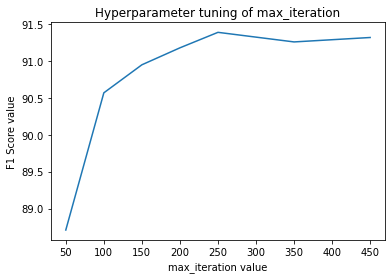

In [30]:
max_iteration_list = [50,100,150,200,250,350,450]
f1_score_list = [88.71, 90.57,90.95,91.18,91.39,91.26,91.32]

sns.lineplot(x=max_iteration_list,y=f1_score_list)
plt.xlabel("max_iteration value")
plt.ylabel("F1 Score value")
plt.title("Hyperparameter tuning of max_iteration")

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [31]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [32]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9196369904608155

### Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

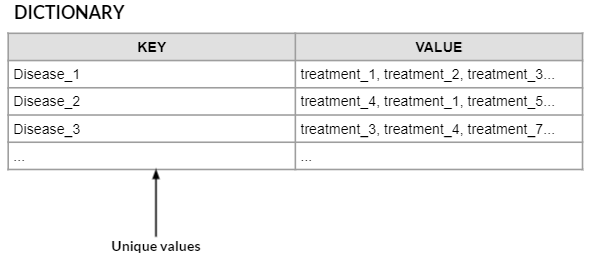

In [33]:
## Mapping diseases with treatment using test sentences and labels 
Mapping_dict=dict()

for lbl in range(0, len(Y_pred)):
  disease_sent=""
  treatment_sent=""
  label=Y_pred[lbl]
  for j in range(0, len(label)):
    if label[j]=='D':
      disease_sent=disease_sent+processed_test_sentences[lbl].split()[j]+" "
    if label[j]=='T':
      treatment_sent=treatment_sent+processed_test_sentences[lbl].split()[j]+" "
    
  disease_sent=disease_sent.lstrip().rstrip()
  treatment_sent=treatment_sent.lstrip().rstrip()
  
  
  if disease_sent!='' and treatment_sent!='':
    if disease_sent in Mapping_dict.keys():
      existing_disease_treatment=list(Mapping_dict[disease_sent]) 
      existing_disease_treatment.append(treatment_sent)
      Mapping_dict[disease_sent]=existing_disease_treatment
    else:
      Mapping_dict[disease_sent]=treatment_sent

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [34]:
Mapping_dict['hereditary retinoblastoma']

'radiotherapy'

In [35]:
result = []
for i in range(0, len(processed_test_sentences)):
    if 'retinoblastoma' in processed_test_sentences[i]:
        print("This is sentence number ", i , "in test data.")
        print("\n*****Sentence*****")
        print(processed_test_sentences[i])
        print("\n*****Test Label*****")
        print(processed_test_labels[i]) 
        print("\n*****Predicted Label*****")
        print(" ".join(Y_pred[i]))

This is sentence number  46 in test data.

*****Sentence*****
< TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy

*****Test Label*****
O O O O O O O O O O O O O O O O O O O O O O O O O

*****Predicted Label*****
O O O O O O O O O O O O O O O O O D D O O O O O T
